# F1: Toy example rank-based empirical p-value

In [4]:
import sys
sys.path.append('../../')
from global_variables import WORKSPACE
import socket
print("Working node:", socket.gethostname())

Working node: irbccn35.hpc.irbbarcelona.pcb.ub.es


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
def get_rank_toy_dist(l, m, n, max_i=5000):
    
    rank = np.random.uniform(l, m, n)
    i = 0
    while sum(rank < 0) > 0:
        rank = np.random.normal(l, m, n)
        i += 1
        if i > max_i:
            print("Max iter reached.")
            return None
    
    return rank

In [7]:
obs_rank = [0.9, 0.8, 0.72, 0.7, 0.68, 0.04]

In [8]:
rank1 = get_rank_toy_dist(l=0.25, m=0.58, n=30)
rank2 = get_rank_toy_dist(l=0.2, m=0.4, n=30)
rank3 = get_rank_toy_dist(l=0.1, m=0.35, n=30)
rank4 = get_rank_toy_dist(l=0.06, m=0.25, n=30)
rank5 = get_rank_toy_dist(l=0.05, m=0.15, n=30)
rank6 = get_rank_toy_dist(l=0, m=0.1, n=30)

rank1 = np.append(rank1, [0.84, 0.59, 0.52, 0.54, 0.65, 0.78])
rank2 = np.append(rank2, [0.36, 0.48, 0.6, 0.55, 0.68, 0.83])
rank3 = np.append(rank3, [0.27, 0.45, 0.63, 0.57, 0.735, 0.79])
rank4 = np.append(rank4, [0.4, 0.6, 0.76, 0.47, 0.71, 0.74])
rank5 = np.append(rank5, [0.41, 0.29, 0.55, 0.69, 0.72, 0.73])
rank6 = np.append(rank6, [0.06, 0.27, 0.16, 0.6, 0.4, 0.5])

ranks = [rank1, rank2, rank3, rank4, rank5, rank6]
sim_ranks = pd.DataFrame({f"R{i}" : ranks[i-1] for i in range(1, 7)})

/tmp/ipykernel_926282/3101764754.py:7: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=sim_ranks, jitter=True, palette=["#629c49"], size=6, marker="o",


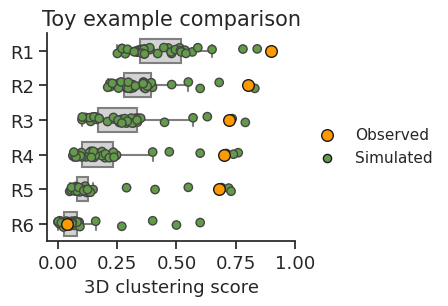

In [9]:
# Create a box plot with dots on top
plt.figure(figsize=(3.2, 2.7))
sns.set(style="ticks", rc={'xtick.labelsize': 13, 'ytick.labelsize': 13})

# Create a box plot with dots on top
sns.boxplot(data=sim_ranks, width=0.7, showfliers=False, orient="h", color="lightgray", zorder=0)
sns.stripplot(data=sim_ranks, jitter=True, palette=["#629c49"], size=6, marker="o", 
              orient="h", linewidth=1, label="Simulated", zorder=1)
plt.scatter(x=obs_rank, y=[f"R{i}" for i in range(1, 7)], zorder=3, color="#FF9900", ec="k", s=70, label="Observed")

sim_patch = plt.scatter([], [], c="#629c49", s=35, label="Simulated", ec="k")
obs_patch = plt.scatter([], [], c="#FF9900", s=70, label="Observed", ec="k")
plt.legend(handles=[obs_patch ,sim_patch], loc="lower center", bbox_to_anchor=(1.31, 0.3), frameon=False)

plt.xticks(np.arange(0, 1.1, 0.25))
plt.title("Toy example comparison", fontsize=15)
plt.xlabel("3D clustering score", fontsize=13)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("../../figures_and_tables/main/f1/f1.toy_example.png", dpi=300, bbox_inches='tight')
plt.show()

## Scoring function

In [10]:
import numpy as np
import pandas as pd
from scipy import stats


def get_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    
    den = stats.binom.logpmf(k=gene_mut, n=gene_mut, p=vec_vol_miss_mut_prob)

    return stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob) / den

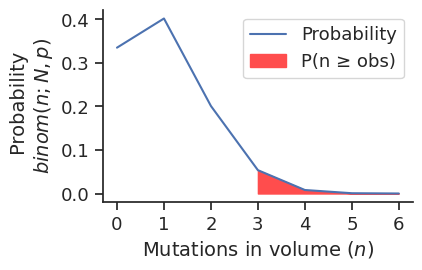

In [11]:
s = 2
N=6
df = pd.DataFrame([(i, stats.binom.pmf(k=i, n=N, p=1/N)) for i in range(N+1)], columns=["Mut_in_vol", "Probability"])

df.plot(x="Mut_in_vol", y="Probability", figsize=(4, 2.5))
plt.fill_between(range(s+1, N+1), df["Probability"][s+1:], np.repeat(0, N-s), color="#ff4d4d", label="P(n ≥ obs)")

# Legend
handles, labels = plt.gca().get_legend_handles_labels()


plt.ylabel("Prob of $\it{s}$ mut hit the volume\n$\it{P(s; N=10, p=0.1)}$", fontsize=14)
plt.ylabel(" Probability\n$\it{binom(n; N, p)}$", fontsize=14)
plt.xlabel("Mutations in volume ($\it{n}$)", fontsize=14)
plt.xticks(range(len(df)), fontsize=13)
plt.yticks(np.arange(0, 0.5, 0.1), fontsize=13)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=13)
plt.savefig("../../figures_and_tables/main/f1/f1.binomial_probability.png", dpi=900, bbox_inches='tight', transparent=True)
plt.show()

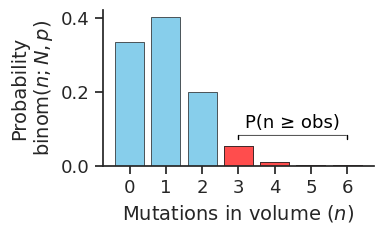

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Parameters
s = 3        # observed threshold
N = 6        # number of trials
p = 1 / N    # success probability

# Build the DataFrame
df = pd.DataFrame({
    "Mut_in_vol": np.arange(N + 1),
    "Probability": stats.binom.pmf(np.arange(N + 1), n=N, p=p)
})

# Make the last two bars more visible
df.loc[4, "Probability"] += 0.0045
df.loc[5, "Probability"] += 0.004
df.loc[6, "Probability"] += 0.003

# Create bar plot
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(
    df["Mut_in_vol"],
    df["Probability"],
    color="skyblue",
    edgecolor="k",
    lw=0.5
)
mask = df["Mut_in_vol"] >= s
ax.bar(
    df["Mut_in_vol"][mask],
    df["Probability"][mask],
    color="#ff4d4d",
    edgecolor="k",
    lw=0.5
)

# Axes labels and ticks
ax.set_xlabel("Mutations in volume ($n$)", fontsize=14)
ax.set_ylabel("Probability\n$\\mathrm{binom}(n; N, p)$", fontsize=14)
ax.set_xticks(df["Mut_in_vol"])
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

# Remove top/right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Draw the horizontal bracket line
ymax = df["Probability"][mask].max()
x0, x1 = s, N
y = ymax + 0.03
ax.annotate(
    '', 
    xy=(x0-0.06, y), 
    xytext=(x1+0.06, y),
    arrowprops=dict(
        arrowstyle='-',
        lw=0.5,
        color='black'
    )
)

# Add short vertical ticks at each end
tick_len = 0.01  # length of the ticks downward
ax.plot([x0, x0], [y, y - tick_len], color='black', lw=1)
ax.plot([x1, x1], [y, y - tick_len], color='black', lw=1)

# Label the bracket with Unicode ≥
xm = 0.5 * (x0 + x1)
ax.text(
    xm, 
    y + 0.01,
    'P(n ≥ obs)',
    ha='center',
    va='bottom',
    fontsize=13,
    color='black'
)

# Final layout and save
plt.tight_layout()
plt.savefig(
    "../../figures_and_tables/main/f1/f1.binomial_probability.png",
    dpi=900,
    bbox_inches='tight',
    transparent=True
)
plt.show()



## Mutational profile

In [13]:
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [14]:
mut_profile_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/mut_profile"
mut_profile_path = f"{mut_profile_path}/TCGA_WXS_COADREAD.sig.json"

with open(mut_profile_path, "r") as f:
    mut_profile_192 = json.load(f)

In [15]:
from itertools import product

def make_96_contexts():
    """
    Build the list of 96 canonical trinucleotide contexts:
      for each substitution in C>A, C>G, C>T, T>A, T>C, T>G
      enumerate all 16 flanking pairs.
    """
    subs = [('C','A'), ('C','G'), ('C','T'),
            ('T','A'), ('T','C'), ('T','G')]
    bases = 'ACGT'
    return [
        f"{l}{ref}{r}>{alt}"
        for ref, alt in subs
        for l, r in product(bases, repeat=2)
    ]

def convert_192_to_96(mut_profile_192):
    """
    Filter a 192-entry dict down to the 96 canonical pyrimidine contexts,
    in the standard order.
    
    Parameters
    ----------
    mut_profile_192 : dict
        Keys like 'ACA>G' or their reverse‐complements, values are rates/counts.
    
    Returns
    -------
    dict
        A 96-entry dict in which each key is one of the canonical
        trinucleotide contexts and each value is pulled directly
        from the input dict.
    """
    ctx96 = make_96_contexts()
    return {ctx: mut_profile_192[ctx] for ctx in ctx96}

mut_profile_96 = convert_192_to_96(mut_profile_192)
mut_profile_96

{'ACA>A': 0.0029187580939583073,
 'ACC>A': 0.003452663638254553,
 'ACG>A': 0.002304776222472677,
 'ACT>A': 0.002173132030791815,
 'CCA>A': 0.0025146096696789812,
 'CCC>A': 0.0024397629445582223,
 'CCG>A': 0.002880782257042729,
 'CCT>A': 0.002782866527935634,
 'GCA>A': 0.004199799544852742,
 'GCC>A': 0.002245210202146067,
 'GCG>A': 0.0029013560071409097,
 'GCT>A': 0.0027091988570845135,
 'TCA>A': 0.003580557388374486,
 'TCC>A': 0.002943670940687428,
 'TCG>A': 0.003921999979568487,
 'TCT>A': 0.004216736360646512,
 'ACA>G': 0.0010658386298162358,
 'ACC>G': 0.001199546741967115,
 'ACG>G': 0.0012100075167981554,
 'ACT>G': 0.001800788536419386,
 'CCA>G': 0.0007121668261572589,
 'CCC>G': 0.0008288638026618146,
 'CCG>G': 0.0009965496761281533,
 'CCT>G': 0.0009891900195169437,
 'GCA>G': 0.0005919806239692543,
 'GCC>G': 0.001048610414561628,
 'GCG>G': 0.0005979145825526876,
 'GCT>G': 0.0009707227175221383,
 'TCA>G': 0.001923597320350123,
 'TCC>G': 0.0013403831076922257,
 'TCG>G': 0.0013299515501

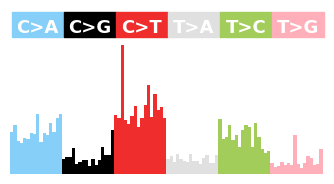

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- your 96-channel data ---
heights = pd.Series(mut_profile_96.values())
heights.iloc[[34,38,42,46]] *= 0.08
channels = np.arange(96)

# --- colors & labels ---
section_colors = ['#86CFF9', '#000000', '#EE2D2C',
                  '#E0E0E0', '#A3CD5B', '#FFAFBA']
section_labels =   ['C>A',      'C>G',     'C>T',
                    'T>A',      'T>C',     'T>G']

# --- plot bars ---
fig, ax = plt.subplots(figsize=(3.5,2))
for i, color in enumerate(section_colors):
    start, end = i*16, (i+1)*16
    ax.bar(channels[start:end],
           heights[start:end],
           color=color,
           width=1.0,
           edgecolor='none')

# --- draw the big stripe with in-block labels ---
stripe_y   = heights.max()*1.06
stripe_h   = heights.max()*0.19   # thicker so text fits
for i, (col, lbl) in enumerate(zip(section_colors, section_labels)):
    x0 = i*16
    # Draw colored block
    ax.add_patch( plt.Rectangle(
        (x0, stripe_y),
        16, stripe_h,
        color=col,
        transform=ax.transData,
        clip_on=False
    ))
    # White label in the middle
    ax.text(x0 + 8,          # center of block
            -0.0002 + stripe_y + stripe_h/2, 
            lbl,
            ha='center', va='center',
            color='white',
            fontsize=13,
            fontweight='bold',
            transform=ax.transData,
            clip_on=False)

# --- clean up ---
ax.set_xlim(-0.5, 95.5)
ax.set_ylim(0, stripe_y + stripe_h*1.1)
ax.axis('off')

plt.savefig(
    "../../figures_and_tables/main/f1/f1.mut_profile.png",
    dpi=900,
    bbox_inches='tight',
    transparent=True
)
plt.tight_layout()
plt.show()


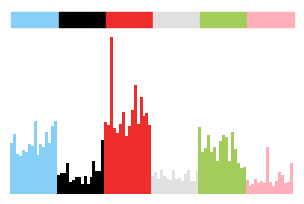

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- your 96-channel data ---
heights = pd.Series(mut_profile_96.values())
heights.iloc[[34,38,42,46]] *= 0.08
channels = np.arange(96)

# --- colors & labels ---
section_colors = ['#86CFF9', '#000000', '#EE2D2C',
                  '#E0E0E0', '#A3CD5B', '#FFAFBA']
section_labels =   ['C>A',      'C>G',     'C>T',
                    'T>A',      'T>C',     'T>G']

# --- plot bars ---
fig, ax = plt.subplots(figsize=(3.2,2.2))
for i, color in enumerate(section_colors):
    start, end = i*16, (i+1)*16
    ax.bar(channels[start:end],
           heights[start:end],
           color=color,
           width=1.0,
           edgecolor='none')

# --- draw the big stripe with in-block labels ---
stripe_y   = heights.max()*1.06
stripe_h   = heights.max()*0.1   # thicker so text fits
for i, (col, lbl) in enumerate(zip(section_colors, section_labels)):
    x0 = i*16
    # Draw colored block
    ax.add_patch( plt.Rectangle(
        (x0, stripe_y),
        16, stripe_h,
        color=col,
        transform=ax.transData,
        clip_on=False
    ))

# --- clean up ---
ax.set_xlim(-0.5, 95.5)
ax.set_ylim(0, stripe_y + stripe_h*1.1)
ax.axis('off')

plt.savefig(
    "../../figures_and_tables/graphical_abstract/mut_profile.png",
    dpi=900,
    bbox_inches='tight',
    transparent=True
)
plt.savefig(
    "../../figures_and_tables/graphical_abstract/mut_profile.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True
)
plt.tight_layout()
plt.show()